# $t$ Process in Scikit Learn

This is a brief demo showcasing the integration of $t$ processess (TP)s into the scikit learn python pacakge.
First, the existing functionality of Gaussian Processes (GP)s will be demonstrated, then the same will be done for TPs.

The stochastic processes will first be demonstrated on a sinewave, then on a data set of \<TODO\>


## Scikit Learn Gaussian Processes Interface

Gaussian processes are a popular method of Bayesian regression used across geostatistics, robotics, finance and more. They are unique in thier ability to offer closed form, uncertaint predictions of unobserved data given noisy observations. They are also able to represent a wide range of data due to the flexibility of the kernel function. A comprehensive review of GPs can be foind at [RW2006].

A simple example of GP regression in scikit learn is as follows:

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, ExpSineSquared
import numpy as np

X_train = np.array([[-3], [-2], [-1], [0], [1], [2], [3]])
Y_train = np.sin(X_train)
X_predict = np.array([[-1.5], [-0.5], [0.5], [1.5]])

kernel = ConstantKernel(1) * RBF(1)

gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0001).fit(X_train, Y_train)
means, stds = gpr.predict(X_predict, return_std=True)

print('\nMean of predictions:')
print(means)
print('\n Standard deviation of predictions:')
print(stds)


Mean of predictions:
[-0.99657464 -0.48004797  0.48004797  0.99657464]

 Standard deviation of predictions:
[0.00887179 0.00866355 0.00866355 0.00887179]


To better visualize the predictions they can be plotted as follows:

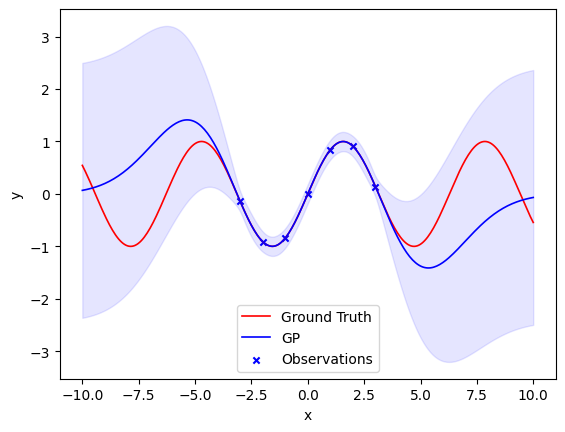

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def norm_conf_gp(std):
    """Returns the 95% confidence interval of the normal distribution"""
    zScore = norm(0, 1).ppf(0.975)
    confidence = zScore * np.sqrt(std)
    return confidence
    
vec_norm_conf_gp = np.vectorize(norm_conf_gp)

X_predict = np.linspace(-10, 10, num=300).reshape(-1, 1)
Y_true = np.sin(X_predict)

means, stds = gpr.predict(X_predict, return_std=True)
confs = vec_norm_conf_gp(stds)
topConf = means + confs
botConf = means - confs

plt.fill_between(np.reshape(X_predict, -1), botConf, topConf, color="blue", alpha=0.1)
plt.plot(X_predict, Y_true, label="Ground Truth", color="red", linewidth=1.2)
plt.plot(X_predict, means, label="GP", color="b", linewidth=1.2)
plt.scatter(
    x=X_train[:, 0],
    y=Y_train,
    color="b",
    alpha=1,
    marker="x",
    s=20,
    label="Observations",
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Given the kernel parameters, the postirior distribution of the GP is calculated using Bayesian statistics. However, it is important to note, the GP's kernel function parameters where optimized using standard likelihood techniqiues. 

This may lead to unpredictible behaviour, and occasionally bizare optimizations.  

## Forked Scikit Learn $t$ Processes Interface

$t$ processes (TP)s are a less common stochastic process, in large part due to their mistery and inability to handle noisy observations analytically. In short, TPs are generated by placing a conjugate prior over the covariance matrix of a GP then subsequently marginalizing it out giving a posterior distribution aver $X$.

There are two primarry advantages of using TPs over GPs:
1. TPs scale the covariance of the stochastic process in a Bayesian way.
2. The marginal distributions of TPs are $t$ distributions, making them *heavier tailed* and thus more roboust to outliers.

Much of the literature focuses on the second property of TPs [SW2014][TW2018][RW2006].

The primary disadvantage of TPs are that they cannot handle noisy observations analytically. This implementation uses the common approach of adding noise to the covariance matrix before a prior is placed over it as proposed by [SW2014]. To see [C2024] for a deeper analysis of this and approximation techniques of noisy TPs.

### $t$ Processes in Scikit Learn

This [fork](https://github.com/conradstevens/scikit-learn) of scikit learn implements TPs as a subclass of GPs giving a simple interface similar to that of GPs in scikit learn. Consider the following example:

In [3]:
from sklearn.gaussian_process import TProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import numpy as np

X_train = np.array([[-3], [-2], [-1], [0], [1], [2], [3]])
Y_train = np.sin(X_train)
X_predict = np.array([[-1.5], [-0.5], [0.5], [1.5]])

kernel = ConstantKernel(1) * RBF(1)

tpr = TProcessRegressor(kernel=kernel, alpha=0.0001).fit(X_train, Y_train)
means, stds = tpr.predict(X_predict, return_std=True)

print('\nMean of predictions:')
print(means)
print('\n Standard deviation of predictions:')
print(stds)


Mean of predictions:
[-0.99661112 -0.47993241  0.47993241  0.99661112]

 Standard deviation of predictions:
[0.00570581 0.00530244 0.00530244 0.00570581]


Remark, the mean values are slighlty different those outputted by the GP as concequence using a different likelihood function for kernel parameter training. This, as well as the Bayesian scaling of the covariance effects the standard deviation values.

Se below the sin wave example using TPs:

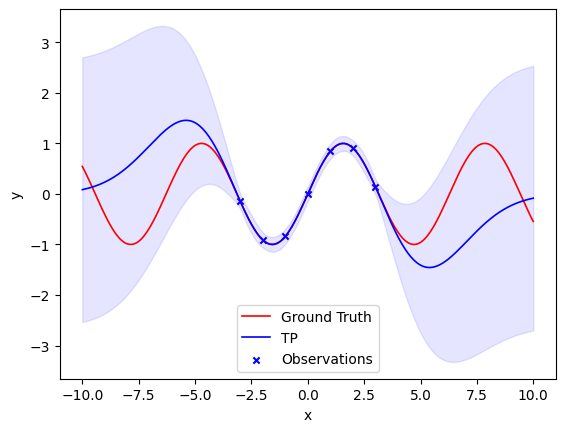

In [4]:
from scipy.stats import t

def norm_conf_tp(std, df):
    """Returns the 95% confidence interval of the normal distribution"""
    tScore = t.ppf(0.975, df)
    confidence = tScore * std
    return confidence

X_predict = np.linspace(-10, 10, num=300).reshape(-1, 1)

means, stds = tpr.predict(X_predict, return_std=True)
confs = vec_norm_conf_gp(stds)
topConf = means + confs
botConf = means - confs

plt.fill_between(np.reshape(X_predict, -1), botConf, topConf, color="blue", alpha=0.1)
plt.plot(X_predict, Y_true, label="Ground Truth", color="red", linewidth=1.2)
plt.plot(X_predict, means, label="TP", color="b", linewidth=1.2)
plt.scatter(
    x=X_train[:, 0],
    y=Y_train,
    color="b",
    alpha=1,
    marker="x",
    s=20,
    label="Observations",
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

The GP plot and TP plot largely look similar as a concequnce of parameter tuning. However, note the marginal distributions of the GP are Gaussian distributions and the marginal distributions of the TP are $t$ distributions.

# Comparing $t$ Processes and Gaussian Processes

\<TODO\>